In [1]:
%load_ext autoreload
%autoreload 2

from importlib import reload

%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

import lmfit

### constants
twopi = 2 * np.pi

# Basic fitting with lmfit models

A very convenient toolset is provided by the lmfit package, in particular when using the model wrappers: https://lmfit.github.io/lmfit-py/model.html

This is a simple example on how to use it, using a simple sine model. All in all it is very simple to use:
* define the fit function. here: a sine with variable frequency, amplitude, phase, and an offset.
* use lmfit to construct a fit model automatically
* make an initial guess
* perform the fit

That is all that's needed in this case. See the lmfit documentation for more details.

<IPython.core.display.Javascript object>


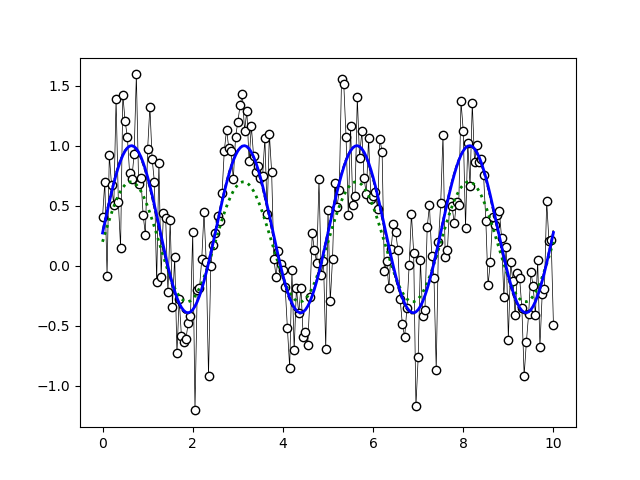

[[Model]]
    Model(sine)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 294
    # data points      = 201
    # variables        = 4
    chi-square         = 26.2573716
    reduced chi-square = 0.13328615
    Akaike info crit   = -401.106986
    Bayesian info crit = -387.893766
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this.  Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    f:      0.40008783 (init = 0.4)
    phi:   -0.04513192 (init = 0)
    of:     0.30496328 (init = 0.2)
    scale:  0.69604289 (init = 0.5)



In [2]:
f = 0.4 # the frequency
phi = 0 * np.pi/2. # the phase
of = 0.3 # offset
scale = 0.7 # scaling factor
noiselevel = 0.4 # scale of added noise (normally distributed)

# define the model
def sine(xs, f, phi, of, scale):
    return scale * np.sin(twopi * f * xs + phi) + of

sinemodel = lmfit.Model(sine)

# make some mock-data
xs = np.linspace(0, 10, 201)
y_ideal = sine(xs, f, phi, of, scale)
y_data = y_ideal + np.random.normal(loc=0, scale=noiselevel, size=xs.size)

# fitting.
# first make the params, and place some initial guess
p0 = sinemodel.make_params(f=0.4, phi=0, of=0.2, scale=0.5)

# perform the fit.
y_guess = sinemodel.eval(p0, xs=xs)
fit_result = sinemodel.fit(y_data, p0, xs=xs, method='nelder')
y_fit = sinemodel.eval(fit_result.params, xs=xs)

# plot: we're plotting the data, the ideal data, the initial guess, and the fit result.
fig, ax = plt.subplots(1, 1)
ax.plot(xs, y_data, 'ko-', mfc='w', mec='k', lw=0.5)
ax.plot(xs, y_ideal, 'k--', lw=1)
ax.plot(xs, y_guess, 'g:', lw=2)
ax.plot(xs, y_fit, 'b', lw=2)

print(fit_result.fit_report())

# Custom lmfit models with guessing

We can save us some manual labor if we're able to automatically determine a good initial guess from the data. That is particularly handy if we want to fit multiple data sets automatically. 

## Example 1: Sine

For our sine example, we can get a guess for frequency and phase from the FFT of the data, and amplitude and offset directly from the data. We can then write a simple extension of the model to include a guess function (see lmfit docs). This works pretty well -- no more manual guessing needed in this case.

<IPython.core.display.Javascript object>


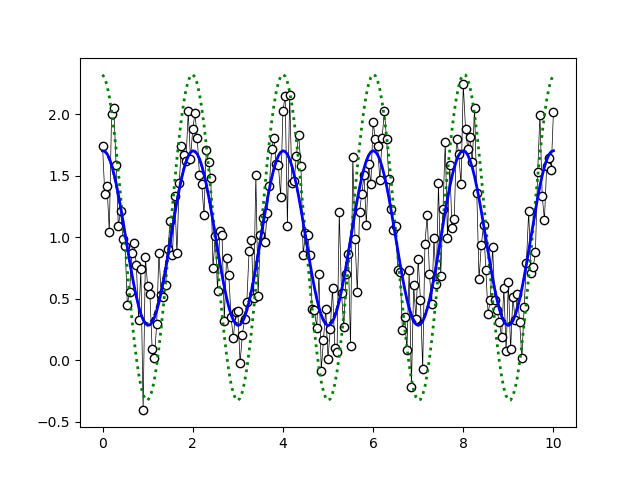

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 149
    # data points      = 201
    # variables        = 4
    chi-square         = 19.4694768
    reduced chi-square = 0.09882983
    Akaike info crit   = -461.225849
    Bayesian info crit = -448.012629
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this.  Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    f:      0.50109058 (init = 0.4975124)
    phi:    1.51642066 (init = 1.629783)
    of:     0.99224780 (init = 0.9973047)
    scale:  0.70988704 (init = 1.325206)



In [3]:
### Define the model class
class SineModel(lmfit.Model):
    
    @staticmethod
    def func(xs, f, phi, of, scale):
        return scale * np.sin(twopi * f * xs + phi) + of
    
    def __init__(self):
        super().__init__(self.func)
        
    def guess(self, data, xs):
        """Simple initial guess from the FFT of the data."""
        dx = (xs[1:]-xs[:-1]).mean()
        ffty = np.fft.rfft(data)
        ffty[0] = 0. # remove the DC component
        fftx = np.fft.rfftfreq(data.size, d=dx)
        fidx = np.argmax(np.abs(ffty))
        
        # make the parameters. notes:
        # * since we're fitting with since, we have to rotate the fft result to get the right frame.
        # * the noisier this 
        p0 = self.make_params(f=fftx[fidx], phi=np.angle(ffty[fidx] * np.exp(1j*np.pi/2.)), 
                              of=data.mean(), scale=(data.max()-data.min())/2.)
        return p0
    
sinemodel = SineModel()


### Example parameters
f = 0.5 # the frequency
phi = np.pi/2. # the phase
of = 1 # offset
scale = 0.7 # scaling factor
noiselevel = 0.3 # scale of added noise (normally distributed)


### make some mock-data
xs = np.linspace(0, 10, 201)
p_ideal = sinemodel.make_params(f=f, phi=phi, of=of, scale=scale)
y_ideal = sinemodel.eval(p_ideal, xs=xs)
y_data = y_ideal + np.random.normal(loc=0, scale=noiselevel, size=xs.size)

### fitting

# first, initial guess. in principle we can still work on p0 if we needed to.
p0 = sinemodel.guess(y_data, xs)
y_guess = sinemodel.eval(p0, xs=xs)

# perform the fit
fit_result = sinemodel.fit(y_data, p0, xs=xs, method='nelder')
y_fit = sinemodel.eval(fit_result.params, xs=xs)

fig, ax = plt.subplots(1, 1)
ax.plot(xs, y_data, 'ko-', mfc='w', mec='k', lw=0.5)
ax.plot(xs, y_ideal, 'k--', lw=1)
ax.plot(xs, y_guess, 'g:', lw=2)
ax.plot(xs, y_fit, 'b', lw=2)

print(fit_result.fit_report())

## Example 2: asymmetric resonator responses

This is a more interesting, real-world example based on complex data. The lmfit model supports complex data out-of-the-box, which is very handy. Below you can find a very simple implementation for fitting asymmetric ('hanger'-type) resonator responses. For the physical model, see Khalil et al., J. Appl. Phys. (2011) (https://arxiv.org/abs/1108.3117). 

Ideal params:
Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q_e_mag           656.9     -inf      inf     None     True     None     None
Q_e_phase         4.449     -inf      inf     None     True     None     None
Q_i            6.425e+04     -inf      inf     None     True     None     None
amp_offset        1.096     -inf      inf     None     True     None     None
amp_slope        0.7607     -inf      inf     None     True     None     None
f0                5e+08     -inf      inf     None     True     None     None
phase_offset      2.446     -inf      inf     None     True     None     None
phase_winding  -1.13e-07     -inf      inf     None     True     None     None

Guessed params:
Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q_e_mag           139.2     -inf      inf     None     True     None     None
Q_e_phase             0     -inf      inf     None     True     None     None
Q_i            2.452e+04   

<IPython.core.display.Javascript object>


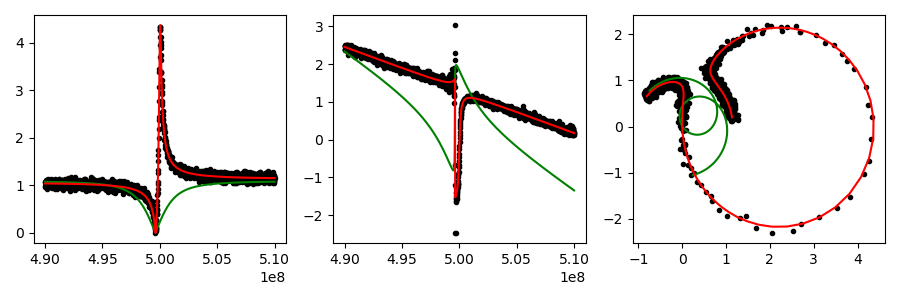

In [14]:
class AssymS21Model(lmfit.Model):
    
    @staticmethod
    def s21_khalil(fs, f0, Q_i, Q_e_mag, Q_e_phase):
        Q_e = Q_e_mag * np.exp(-1j * Q_e_phase)
        Q_c = 1./((1./Q_e).real)
        Q_tot = 1./(1./Q_i + 1./Q_c)
        return 1. - (Q_tot/Q_e_mag * np.exp(1j*Q_e_phase)) / (1 + 2j * Q_tot * (fs-f0)/f0)
    
    @staticmethod
    def func(fs, f0, Q_i, Q_e_mag, Q_e_phase, amp_slope, amp_offset, phase_winding, phase_offset):
        sig = AssymS21Model.s21_khalil(fs, f0, Q_i, Q_e_mag, Q_e_phase)
        sig *= amp_offset * (1. + amp_slope * (fs-f0)/f0)
        sig *= np.exp(1j * (phase_offset + phase_winding * (fs-fs[0])))
        return sig
    
    def __init__(self):
        super().__init__(self.func)
        
    def guess(self, data, fs, edge_fracs=(20, 20)):
        e0, e1 = edge_fracs
        
        mag, phi = np.abs(data), np.angle(data)
        npts = fs.size
        
        # some basic metrics of the data
        avg0 = data[:npts//e0].mean()
        avg1 = data[-npts//e1:].mean()
        mag_std = np.abs(data[:npts//e0]).std()
        mag_avg = (np.abs(avg0) + np.abs(avg1))/2.
        mag_min = mag.min()/mag_avg
        
        # guess for resonance is simply the minimal magnitude
        f0 = fs[np.argmin(np.abs(mag-mag_avg))]
                
        # guess for Q: guess line width from fraction of points that lie a certain
        # distance from the mean. then compute Qs from that.
        noutliers = np.where((mag < (mag_avg - 3.*mag_std)) | (mag > (mag_avg + 3.*mag_std)))[0].size
        fracoutliers = 0.5 * noutliers / fs.size
        fwhm = np.abs(fs[-1] - fs[0]) * fracoutliers
        Ql = f0/fwhm
        Qi = Ql/mag_min
        Qc = Ql/np.abs(1.-mag_min)
        
        # phase winding:
        # look at the average derivative at the edges, and ignore obvious jumps
        phase_diffs = np.append(np.diff(phi)[:npts//e0], np.diff(phi)[-npts//e1])
        phase_winding = phase_diffs[np.abs(phase_diffs)<np.pi/8.].mean()
        
        p0 = self.make_params(
            f0 = fs[np.argmin(mag)],
            Q_i = Qi,
            Q_e_mag = Qc,
            Q_e_phase = 0,
            amp_slope = 0,
            amp_offset = mag_avg,
            phase_winding = phase_winding / (fs[1]-fs[0]),
            phase_offset = phi[0],
        )
        
        return p0
        
s21model = AssymS21Model()


### Example parameters and mock data
amp = 1 + 0.2 * np.random.rand() - 0.1

p_ideal = s21model.make_params(
    f0 = 5e8,
    Q_i = 10000 + np.random.rand() * 1e5,
    Q_e_mag = 500 + np.random.rand() * 2.5e2,
    Q_e_phase = np.random.rand() * twopi,
    amp_slope = np.random.rand() * 1.,
    amp_offset = amp,
    phase_winding = (np.random.rand() - 0.5) * 0.5e-6,
    phase_offset = np.random.rand() * twopi - np.pi,
)

print('Ideal params:')
p_ideal.pretty_print()
print('')

fs = np.linspace(4.9, 5.1, 2001) * 1e8
y_ideal = s21model.eval(p_ideal, fs=fs)

# for mock data, add real and imaginary noise
y_data = y_ideal + np.random.normal(scale=amp*0.05, size=fs.size) + 1j*np.random.normal(scale=amp*0.05, size=fs.size)


### fitting

p_guess = s21model.guess(y_data, fs)
print('Guessed params:')
p_guess.pretty_print()
print('')

# let's assume we've measured some of our line properties beforehand, and can fix them
# to an independently established value
# p_guess['phase_winding'].vary = False
# p_guess['phase_offset'].vary = False


y_guess = s21model.eval(p_guess, fs=fs)
fit_result = s21model.fit(y_data, p_guess, fs=fs, 
                          method='leastsq', fit_kws=dict(xtol=1e-10, ftol=1e-10))
y_fit = s21model.eval(fit_result.params, fs=fs)

print('Fit:')
print(fit_result.fit_report())


### plotting
fig, axes = plt.subplots(1, 3, figsize=(9,3))

# magnitude
ax = axes[0]
ax.plot(fs, np.abs(y_data), 'k.')
ax.plot(fs, np.abs(y_guess), 'g-')
ax.plot(fs, np.abs(y_fit), 'r-')

# phase
ax = axes[1]
ax.plot(fs, np.angle(y_data), 'k.')
ax.plot(fs, np.angle(y_guess), 'g-')
ax.plot(fs, np.angle(y_fit), 'r-')

# circle
ax = axes[2]
ax.plot(y_data.real, y_data.imag, 'k.')
ax.plot(y_guess.real, y_guess.imag, 'g-')
ax.plot(y_fit.real, y_fit.imag, 'r-')

fig.tight_layout()

# Cq analysis fit tools

In [4]:
from cq_analysis import fit

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 201
    # variables        = 4
    chi-square         = 31.2630910
    reduced chi-square = 0.15869589
    Akaike info crit   = -366.034208
    Bayesian info crit = -352.820989
[[Variables]]
    f:      0.39827825 +/- 0.00298874 (0.75%) (init = 0.39801)
    phi:    0.09414994 +/- 0.10889493 (115.66%) (init = 0.102507)
    of:     0.31421070 +/- 0.02809947 (8.94%) (init = 0.3142303)
    scale:  0.72703078 +/- 0.03984366 (5.48%) (init = 1.680094)
[[Correlations]] (unreported correlations are < 0.100)
    C(f, phi) = -0.865



<IPython.core.display.Javascript object>


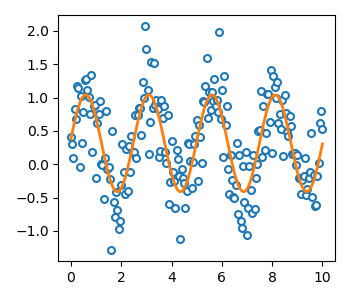

In [6]:
# choose a model
sinemodel = fit.models.sine.Model()

# make some fake data based on the model
f = 0.4 # the frequency
phi = 0 * np.pi/2. # the phase
of = 0.3 # offset
scale = 0.7 # scaling factor
noiselevel = 0.4 # scale of added noise (normally distributed)

xs = np.linspace(0, 10, 201)
p_ideal = sinemodel.make_params(f=f, phi=phi, of=of, scale=scale)
y_data = sinemodel.eval(p_ideal, xs=xs) + np.random.normal(loc=0, scale=noiselevel, size=xs.size)

# the entire fit is now automatic.
fitresult, plot = fit.fit1d(sinemodel, y_data, xs, guess_kws=dict(xs=xs))